## 用于演示导入pytorch模型

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
# ========== 模型：LeNet-5 ==========
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # C1: 1x32x32 -> 6x28x28 (5x5 conv, no padding)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True)
        # S2: AvgPool 6x28x28 -> 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: 6x14x14 -> 16x10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True)
        # S4: AvgPool 16x10x10 -> 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: 16x5x5 -> 120x1x1  (经典 LeNet-5 的 conv 当作全连接)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=True)

        # F6: 120 -> 84
        self.fc1 = nn.Linear(120, 84)
        # OUTPUT: 84 -> 10
        self.fc2 = nn.Linear(84, num_classes)

        # 经典 LeNet 使用 Tanh
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.act(self.conv3(x))        # [B, 120, 1, 1]
        x = x.view(x.size(0), -1)          # [B, 120]
        x = self.act(self.fc1(x))          # [B, 84]
        x = self.fc2(x)                    # [B, 10]
        return x

In [3]:
# ========== 加载模型 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)

checkpoint = torch.load("lenet5_mnist.pt", map_location=device)
model.load_state_dict(checkpoint["model"])
model.eval()

print(f"Loaded model trained up to epoch {checkpoint['epoch']} "
      f"with best acc {checkpoint['acc']*100:.2f}%")

Loaded model trained up to epoch 8 with best acc 98.65%


Ground Truth label: 7, Predicted label: 7


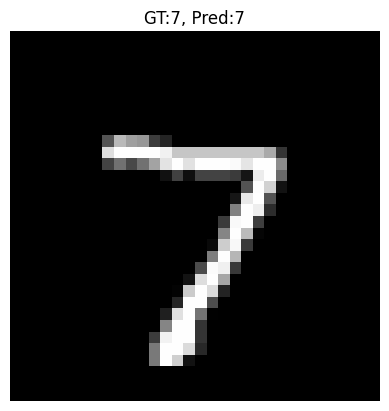

In [4]:
# ========== 准备数据 ==========
transform = transforms.Compose([
    transforms.Pad(2),   # MNIST 28x28 -> 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_set = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 取一张样本
img, label = test_set[0]
x = img.unsqueeze(0).to(device)   # 增加 batch 维度

# ========== 推理 ==========
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(dim=1).item()

print(f"Ground Truth label: {label}, Predicted label: {pred}")

# ========== 可视化 ==========
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"GT:{label}, Pred:{pred}")
plt.axis("off")
plt.show()